# Lab 5 - Exercise
Author 1: Connor Gasgarth

Author 2: Jack Ditto

## Rubric
1. Generated correct template plots for three different notes.
2. Correct calculation of `calculate_likelihood` and `calculate_all_likelihoods`. Straightforward coding style (e.g., clear and simple logic with moderate amount of comments; accurate and descriptive variable names).
3. The first frame was correctly recognized, and the observation and the midi template are in the same plot. The second frame was incorrectly recognized, and the observation and the templates of the correct and incorrect midi numbers are in the same plot.

Please submit both the Notebook file (.ipynb) and the Python file (.py).

## Estimating Notes in (Monophonic) Music Audio Recordings
Please download the audio example called `bass_oboe.wav` from Blackboard. We'll write a program to recognize each note in this audio recording using the **template matching** and **maximum likelihood** methods.

### PART I: Examing Note Templates
Please don't change the provided code in this part. The following few functions create the frequency profile templates for Midi note ranging from 47 to 72. At the end of the block, please choose at least three midi notes (within the range), and write code to plot their templates. You may either plot them separately, or put them in the same plot (with different colors).

In [29]:
import librosa
import math
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import IPython.display as ipd

# Global variables
LOW_MIDI = 47
HIGH_MIDI = 72

def peak_fun(x):
    """
    Constructs and returns a harmonic peak
    """
    return math.exp(-0.5*x*x)


def midi2freq(midi):
    """
    Returns the frequency (in Hz) of the given midi number
    """
    return 440*np.power(2, (midi-69)/12)


def template(midi, N, sr):
    """
    Returns a frequency profile template for the given midi note.
        midi: midi number
        N: frame size (must be an even number)
        sr: sample rate
    """
    if N % 2 != 0:
        print("Frame size is not even!")
        return None
    f0 = midi2freq(midi) # fundamental frequency
    H = 13 # maximumn number of harmonics to include
    bins = math.floor(N/2) # half of the DFT result
    template = np.zeros(bins) 
    
    for h in range(1, H+1): # h = 1, 2, 3, ..., H
        bin = round(f0*h*N/sr) # bin index of this harmonic
        if bin >= bins: # exceeds Nyquist frequency
            break
        sigma = bin * 0.01 + 0.01 # controls the width of the peak
        for k in range(bins):
            x = (k-bin)/sigma
            template[k] += math.exp(-k*0.01) * peak_fun(x) # descreasing amplitudes for higher frequencies
    
    for k in range(bins):
        template[k] += 2.2250738585072014e-200 # to avoid zeros in our template
    # Normalize all bins:
    total = sum(template)
    if (total > 0):
        template = template / total
    else:
        print("The template has 0 everywhere!")
    return template


def create_templates(N, sr):
    """
    Returns a dictionary where the key is a midi number (or 0) and
    the value is the template of this midi note.
    (silence is represented by 0)
    """
    templates = {}
    for midi in range(LOW_MIDI, HIGH_MIDI + 1):
        templates[midi] = template(midi, N, sr)
    templates[0] = np.repeat(1/math.floor(N/2), math.floor(N/2))
    return templates

In [30]:

created_templates = create_templates(1024, 8000)

# plt.plot(created_templates[LOW_MIDI])
# plt.show()
# plt.plot(created_templates[56])
# plt.show()
# plt.plot(created_templates[HIGH_MIDI])
# plt.show()

### PART II: Calculating Likelihoods Using Template Matching

Task: Finish the implementation of the following two functions. `calculate_likelihood` calculate the log likelihood of an observed spectrum given a hypothesized template. Please use the formula below, where $I$ is the length of the observation.

$$
\begin{align}
\text{log likelihood} &= \log\big(\prod_{i=0}^{I-1}\text{Template}(i)^{\text{Observation}(i)}\big)\\
&= \sum_{i=0}^{I-1}\Big(\text{Observation}(i)\times\log\big(\text{Template}(i)\big)\Big) \rightarrow\text{use this one for your code!}
\end{align}
$$

The second function `calculate_all_likelihoods` repeatedly calls the first function and caculates the likelihoods for all frames in the spectrogram. You'll need two nested for loops — one is already provided.

In [31]:
def calculate_likelihood(tmplt, spectrum):
    """
    Calculates and returns the log-likelihood of observing the spectrum given the template.
    (It should be a negative number.)
        T: the spectral template
        spectrum: the observed spectrum of a frame
        (T and spectrum must have the same length.)
    """
    spectrum = spectrum / np.sum(spectrum) # Normalizing this signal (so to ignore volumn).
    if (len(tmplt) != len(spectrum)):
        print("The length of the spectrum and the template doesn't match!")
        return None
    
    like = float(0)
    for i in range(len(spectrum)):
        like += spectrum[i] * math.log(tmplt[i])

    return like


def calculate_all_likelihoods(templates, spectrogram):
    """
    Calculates and returns all the likelihoods of observing each frame in the spectogram
    given each template. The returned value is a two-dimensional array. The row indice represent
    midi numbers, and column indices are the frame indices. Note that Row 1 - Row (LOW_MIDI-1)
    are all zeros because they are not considered in our program.
        templates: a dictionary containing the spectral templates of all possible notes (including silence)
        spectrogram: the observed spectrogram including all frames (dimension: bins rows * frames columns)
        (The length of the templates must be the same as the numbers of rows in spectrogram.)
    """
    
    T = spectrogram.shape[1] # the total number of frames
    likelihoods = np.zeros((HIGH_MIDI+1, T)) # DON'T CHANGE
    for t in range(T): # DON'T CHANGE
        for s in range(LOW_MIDI, HIGH_MIDI + 1):
            likelihoods[s, t] = calculate_likelihood(templates[s], spectrogram[:,t])
            
    return likelihoods # DON'T CHANGE

### PART 3: Choosing the Maximum Likelihood and See the Result
If your PART 2 is implemented correctly, running the following code would show you the recognition result: the second figure shows the midi note that has the highest likihood at each frame.

After you are sure the code is working, (write code to) zoom in to the plot to find two frames:
1. Select a correctly recognized frame, and plot the observed spectrum of that frame together with the template of the real midi. Their peaks should overlap nicely.
2. Select an *incorrectly* recognized frame, and plot the observed spectrum of that frame together with the templates of the real midi *and* the incorrectly identified midi (so all three in one plot). Then, write your answer in one or two sentences: What might be the reason why this frame was recognized as the incorrect midi?

There were no miss predictions

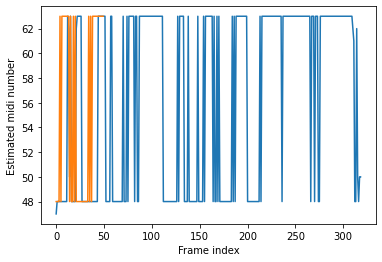

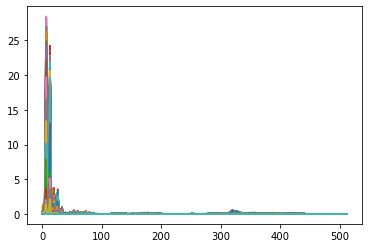

In [33]:
import librosa
import math
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import IPython.display as ipd

def read_wav(file_path, sr):
    """
    Returns the samples in the audio file.
    """
    samples, sr = librosa.load(file_path, sr = sr)
    return samples


def identify_notes(samples, sr, framesize):
    """
    Use template matching and maximum likelihood to recognize notes in the audio sample.
    Assuming the sample rate is 8000 (Hz).
    """
    
    sr = sr # DON'T CHANGE
    N = framesize # DON'T CHANGE
    hop = int(N/2) # DON'T CHANGE
    
    ## Calculate STFT
    T = math.floor( (len(samples)-N) / hop ) + 1 # the total number of frames
    STFT = np.zeros((N, T), dtype='complex') # the STFT result will be a N by T matrix
    hann = 0.5 * ( 1 - np.cos(2*np.pi*np.arange(N)/N) ) # our Hann window
    for t in range(T): # for each frame
        chunck = samples[t*hop : t*hop + N] # get the frame t of audio data
        X = fft(chunck * hann) # apply FFT on windowed signal (the result contains N complex numbers)
        STFT[:, t] = X
    
    ## Show spectrogram
    spect = np.abs(STFT[:int(N/2), :]) # complex numbers --> abs values
    # plt.imshow(spect[:, :], origin='lower', cmap='gray_r', aspect='auto')
    # plt.title('Spectrogram')
    # plt.xlabel('Frame index')
    # plt.ylabel('Frequency index')
    # plt.show()
    
    ## Create templates
    all_templates = create_templates(N, sr)
    
    ## Calculate log-likelihoods for each midi at each frame
    all_likelihoods = calculate_all_likelihoods(all_templates, spect)
    
    ## For each frame, find the midi with the largest likelihood
    notes = np.zeros(T)
    for t in range(T):
        likelihoods = all_likelihoods[:, t]
        largest_likelihood = -float("inf") # smallest float number
        for midi in range(LOW_MIDI, HIGH_MIDI + 1): # Doesn't include 'silence' here
            if likelihoods[midi] > largest_likelihood:
                largest_likelihood = likelihoods[midi]
                notes[t] = midi
    # print(notes)
    plt.plot(notes)
    plt.plot(notes[150:200])
    plt.xlabel('Frame index')
    plt.ylabel('Estimated midi number')
    plt.show()
    plt.plot(spect[:])
    plt.plot(created_templates[72])
    plt.show()



samples, sr = librosa.load("s1.wav", sr = None)
identify_notes(samples, sr, 1024) #65536